# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [ ]:
! pip install SimpleITK 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Downloading the data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
! unzip brainage-data.zip

--2023-03-02 15:27:19--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip.7’

brainage-data.zip.7 100%[===================>] 446.94M  14.7MB/s    in 32s     

2023-03-02 15:27:53 (13.8 MB/s) - ‘brainage-data.zip.7’ saved [468654948/468654948]

Archive:  brainage-data.zip
replace data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.ni

### Setting data directory

In [ ]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [ ]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

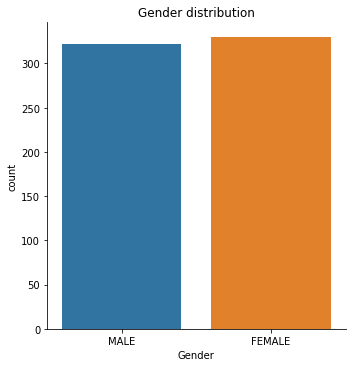

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


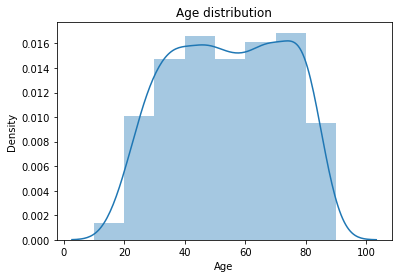

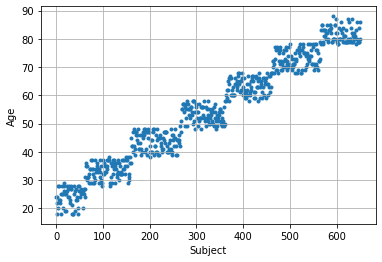

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


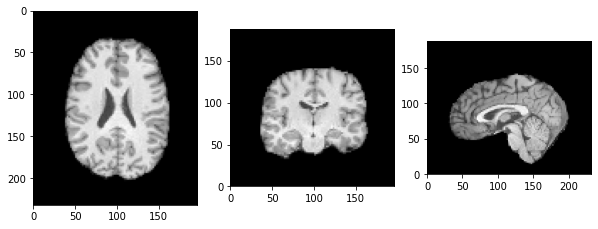

Brain mask


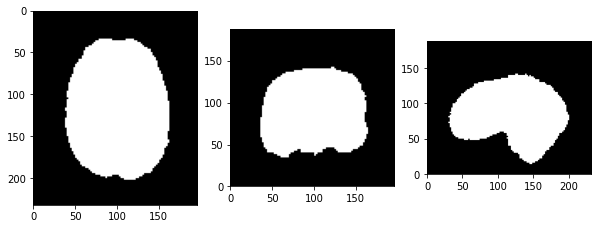

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [ ]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [ ]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 40
learning_rate = 0.001
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [ ]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [ ]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


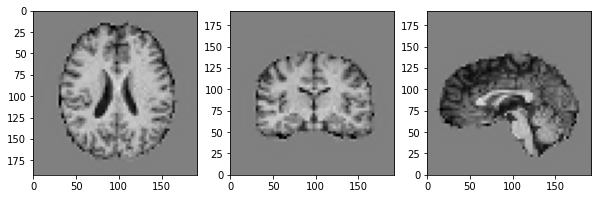

Segmentation


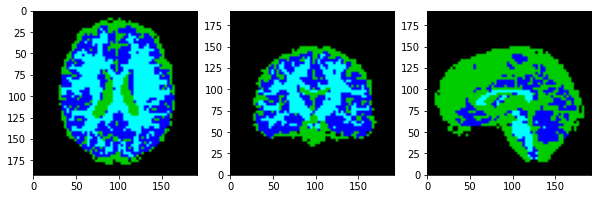

Mask


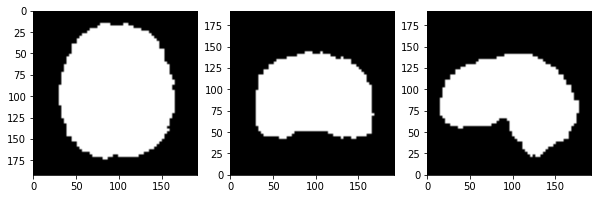

In [ ]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [ ]:
########################################
# BUILD A BETTER MODEL HERE
########################################


class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Block, self).__init__()

        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.relu1  = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm3d(out_ch)

    def forward(self, x):
          x = self.conv1(x)
          x = self.batch_norm1(x)
          x = self.relu1(x)
          return x


class Encoder(nn.Module):
    def __init__(self, input_channels=1 , chs = [32,64,128,256,512]):
        super(Encoder, self).__init__()

        #Encoder downsapling blocks

        self.conv_1 = Block(input_channels, chs[0])
        self.conv_2 = Block(chs[0], chs[1])
        self.conv_3 = Block(chs[1], chs[2])
        self.conv_4 = Block(chs[2], chs[3])
        self.conv_5 = Block(chs[3], chs[4])
        
    
    def forward(self, x):
        ftrs = []

        x1 = self.conv_1(x)
        x1_downsamp = F.max_pool3d(x1, kernel_size=2, stride=2, padding=0, ceil_mode = False)

        x2 = self.conv_2(x1_downsamp)
        x2_downsamp = F.max_pool3d(x2, kernel_size=2, stride=2, padding=0, ceil_mode = False)

        x3 = self.conv_3(x2_downsamp)
        x3_downsamp = F.max_pool3d(x3, kernel_size=2, stride=2, padding=0, ceil_mode = False)

        x4 = self.conv_4(x3_downsamp)
        x4_downsamp = F.max_pool3d(x4, kernel_size=2, stride=2, padding=0, ceil_mode = False)

        x5 = self.conv_5(x4_downsamp)
            
        ftrs = [x1,x2,x3,x4,x5]
        
  
        return ftrs



class Decoder(nn.Module):
    def __init__(self, chs = [32,64,128,256,512]):
        super().__init__()
        self.chs        = chs



        #Decoding Upconvolutions

        self.upconv_4 = nn.ConvTranspose3d(chs[4], chs[3], 2,2)
        self.upconv_3 = nn.ConvTranspose3d(chs[3], chs[2], 2,2)
        self.upconv_2 = nn.ConvTranspose3d(chs[2], chs[1], 2,2)
        self.upconv_1 = nn.ConvTranspose3d(chs[1], chs[0], 2,2)

        #Decoder Convolution Blocks
        self.deconv_4 = Block(2*chs[3], chs[3])
        self.deconv_3 = Block(2*chs[2], chs[2])
        self.deconv_2 = Block(2*chs[1], chs[1])
        self.deconv_1 = Block(2*chs[0], chs[0])


        #self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 

        
    def forward(self, encoder_features):

        x6 = torch.cat([self.upconv_4(encoder_features[4]),encoder_features[3]], dim=1)
        x6_h = self.deconv_4(x6)

        x7 = torch.cat([self.upconv_3(x6_h),encoder_features[2]], dim=1)
        x7_h = self.deconv_3(x7)      

        x8 = torch.cat([self.upconv_2(x7_h),encoder_features[1]], dim=1)
        x8_h = self.deconv_2(x8)

        x9 = torch.cat([self.upconv_1(x8_h),encoder_features[0]], dim=1)
        x9_h = self.deconv_1(x9)

        return x9_h

class SimpleUNet3D(nn.Module):
    def __init__(self, input_channels=1, num_classes=4, chs = [32,64,128,256,512]):
      super(SimpleUNet3D, self).__init__()

      self.encoder = Encoder(input_channels=1,chs = [32,64,128,256,512])

      self.decoder = Decoder(chs = [32,64,128,256,512])

      self.final_chs = nn.Conv3d(chs[0], num_classes, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self,x):

      enc_ftrs = self.encoder(x)
      dec_x = self.decoder(enc_ftrs)

      final = self.final_chs(dec_x)

      #print(final.shape)

      return final




class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 6, kernel_size=3,padding=1)
        self.conv2 = nn.Conv3d(6, 16, kernel_size=3,padding=1)
        self.conv3 = nn.Conv3d(16, 120, kernel_size=3,padding=1)
        self.conv4 = nn.Conv3d(120, 84, kernel_size=3,padding=1)
        self.conv5 = nn.Conv3d(84, num_classes, kernel_size=1)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = F.log_softmax(x, dim=1)
        
        return x # cross-entropy loss expects raw logits and applies softmax




#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.624280
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.615534


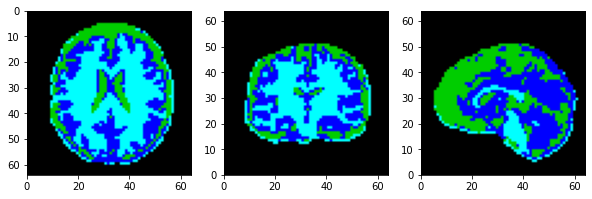

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.442929
+ TRAINING 	Epoch: 3 	Loss: 0.324014
+ TRAINING 	Epoch: 4 	Loss: 0.248485
+ TRAINING 	Epoch: 5 	Loss: 0.189765
+ TRAINING 	Epoch: 6 	Loss: 0.156174
+ TRAINING 	Epoch: 7 	Loss: 0.137235
+ TRAINING 	Epoch: 8 	Loss: 0.122575
+ TRAINING 	Epoch: 9 	Loss: 0.137007
+ TRAINING 	Epoch: 10 	Loss: 0.103051
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.116061


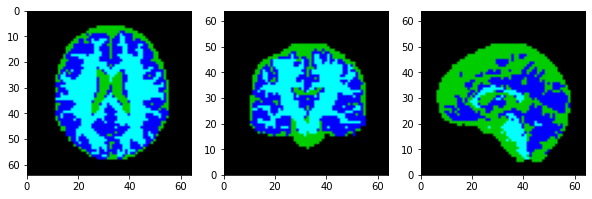

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.156109
+ TRAINING 	Epoch: 12 	Loss: 0.111404
+ TRAINING 	Epoch: 13 	Loss: 0.105729
+ TRAINING 	Epoch: 14 	Loss: 0.100488
+ TRAINING 	Epoch: 15 	Loss: 0.097311
+ TRAINING 	Epoch: 16 	Loss: 0.092432
+ TRAINING 	Epoch: 17 	Loss: 0.078854
+ TRAINING 	Epoch: 18 	Loss: 0.085704
+ TRAINING 	Epoch: 19 	Loss: 0.090690
+ TRAINING 	Epoch: 20 	Loss: 0.076019
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.090728


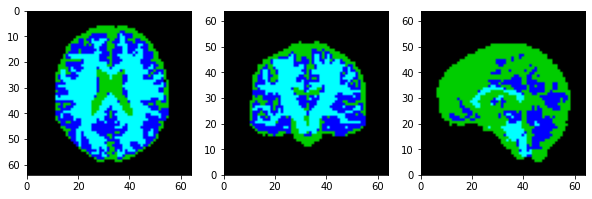

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.118868
+ TRAINING 	Epoch: 22 	Loss: 0.074706
+ TRAINING 	Epoch: 23 	Loss: 0.089585
+ TRAINING 	Epoch: 24 	Loss: 0.085889
+ TRAINING 	Epoch: 25 	Loss: 0.098195
+ TRAINING 	Epoch: 26 	Loss: 0.076671
+ TRAINING 	Epoch: 27 	Loss: 0.079272
+ TRAINING 	Epoch: 28 	Loss: 0.068609
+ TRAINING 	Epoch: 29 	Loss: 0.065339
+ TRAINING 	Epoch: 30 	Loss: 0.083008
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.079925


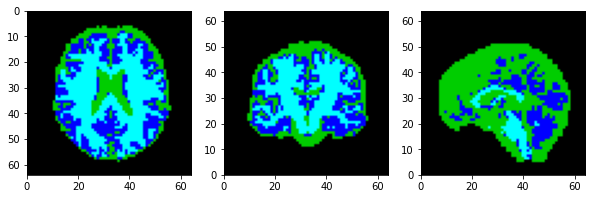

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.104218
+ TRAINING 	Epoch: 32 	Loss: 0.072967
+ TRAINING 	Epoch: 33 	Loss: 0.088479
+ TRAINING 	Epoch: 34 	Loss: 0.071560
+ TRAINING 	Epoch: 35 	Loss: 0.066799
+ TRAINING 	Epoch: 36 	Loss: 0.058035
+ TRAINING 	Epoch: 37 	Loss: 0.072876
+ TRAINING 	Epoch: 38 	Loss: 0.072195
+ TRAINING 	Epoch: 39 	Loss: 0.065044
+ TRAINING 	Epoch: 40 	Loss: 0.060212
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.072973


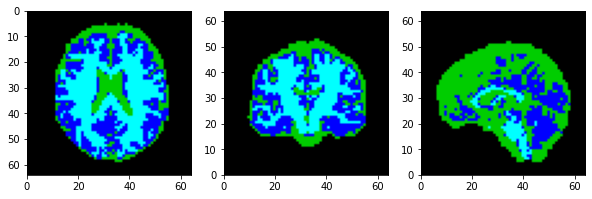

--------------------------------------------------

Finished TRAINING.


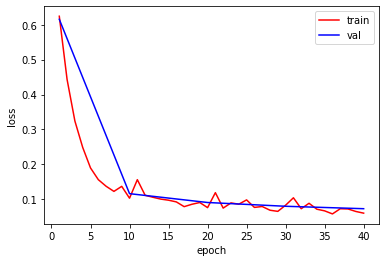

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleUNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []

    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]



dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:26<00:00,  5.75it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


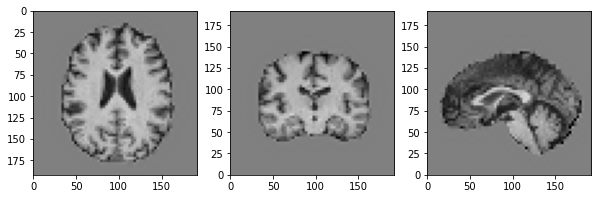

Segmentation


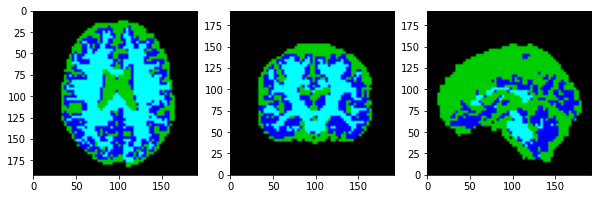

Mask


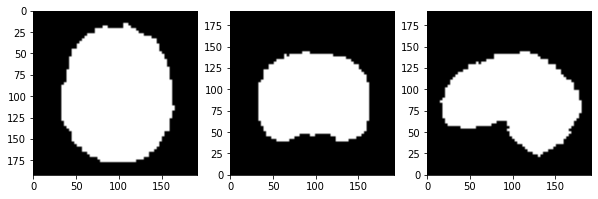

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

START TESTING...
+ TESTING 	Loss: 0.079008


Reference segmentation


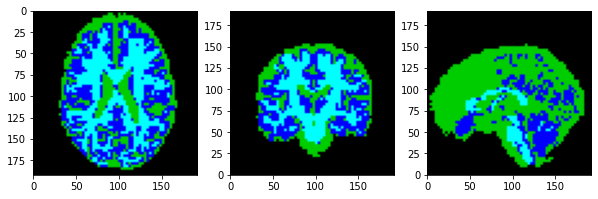

Predicted segmentation


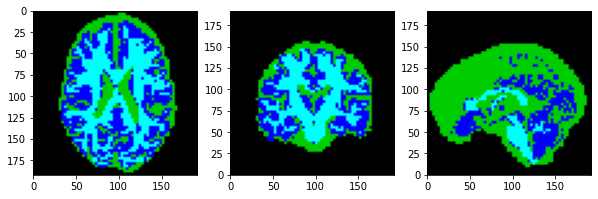

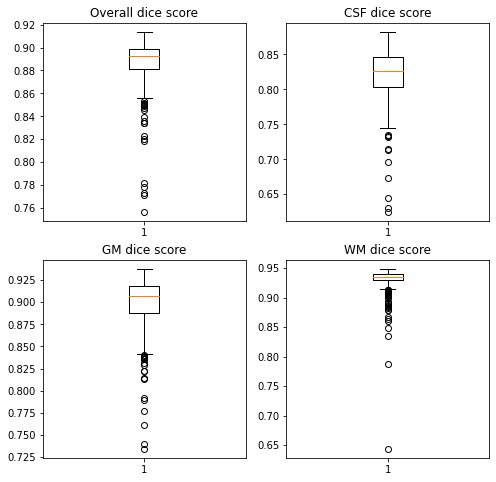

FINISHED TESTING


In [ ]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
model = SimpleUNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')
loss_test = 0
sum_pts = 0
idx_test = 0
###
dice_scores = []
dice_scores_csf = []
dice_scores_gm = []
dice_scores_wm = []
#overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
###
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)
        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        # Calculate dice score
        ref = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        ref.CopyInformation(sample['seg'])
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
        overlap_measures_filter.Execute(ref, prediction)
        dice_scores.append(overlap_measures_filter.GetDiceCoefficient())
        
        overlap_measures_filter.Execute((ref == 1), (prediction == 1))
        dice_scores_csf.append(overlap_measures_filter.GetDiceCoefficient())
        overlap_measures_filter.Execute((ref == 2), (prediction == 2))
        dice_scores_gm.append(overlap_measures_filter.GetDiceCoefficient())
        overlap_measures_filter.Execute((ref == 3), (prediction == 3))
        dice_scores_wm.append(overlap_measures_filter.GetDiceCoefficient())
        
        
        idx_test += 1
        
loss_test /= sum_pts
print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
###
# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))
# Plot dice scores
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0,0].boxplot(dice_scores)
axs[0,0].set_title("Overall dice score")
axs[0,1].boxplot(dice_scores_csf)
axs[0,1].set_title("CSF dice score")
axs[1,0].boxplot(dice_scores_gm)
axs[1,0].set_title("GM dice score")
axs[1,1].boxplot(dice_scores_wm)
axs[1,1].set_title("WM dice score")
plt.show()
print('FINISHED TESTING')

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)

        segarray = sitk.GetArrayFromImage(seg)

        csf = np.sum(segarray == 1)
        gm = np.sum(segarray == 2)
        wm = np.sum(segarray == 3)

        vols[0,idx] = csf
        vols[1,idx] = gm
        vols[2,idx] = wm
        
        

Calculating Features: 100%|██████████| 500/500 [00:01<00:00, 257.15it/s]


Plot features versus age.

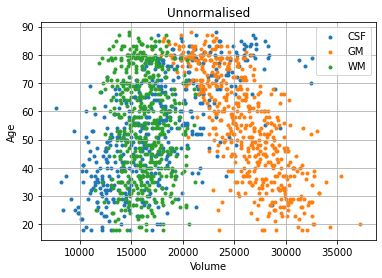

In [ ]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)

        segarray = sitk.GetArrayFromImage(seg)
         
        csf = np.sum(segarray == 1)
        gm = np.sum(segarray == 2)
        wm = np.sum(segarray == 3)

        total_brain_pixels = csf + gm + wm


        vols_normalised[0,idx] = csf/total_brain_pixels
        vols_normalised[1,idx] = gm/total_brain_pixels
        vols_normalised[2,idx] = wm/total_brain_pixels



Calculating Features: 100%|██████████| 500/500 [00:02<00:00, 218.95it/s]


Plot normalised features versus age.

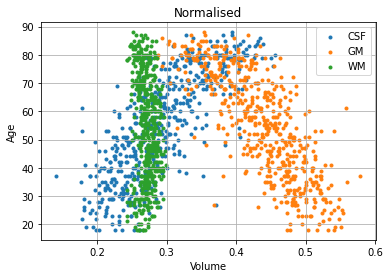

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [ ]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [ ]:
# Import required libraries
from sklearn import datasets, linear_model, svm, tree, preprocessing
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Load dataset (assuming 'X' and 'y' are already defined)

# Normalize the input features
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X)

# Define regression models
lin_regr = linear_model.LinearRegression()
svm_regr = svm.SVR()
tree_regr = tree.DecisionTreeRegressor()
#nn_regr = MLPRegressor()
rf_regr = RandomForestRegressor(n_estimators=100)

# Define a range of hyperparameters to search over for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.1, 0.2, 0.5]
}

# Define a range of hyperparameters to search over for decision tree
tree_param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8]
}

# Define a range of hyperparameters to search over for neural network
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'max_iter': [300, 500, 1000]
}


# Define a range of hyperparameters to search over for random forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8]
}


# Define a K-fold cross-validation object with 2 splits
kfold = KFold(n_splits=2, shuffle=True, random_state=1)

# Perform linear regression
lin_y_pred = cross_val_predict(lin_regr, X_norm, y, cv=kfold)
lin_mae = mean_absolute_error(y, lin_y_pred)
lin_r2 = r2_score(y, lin_y_pred)

print(lin_mae,' ',lin_r2)

# Perform support vector regression with grid search
svm_grid_search = GridSearchCV(svm_regr, svm_param_grid, cv=kfold, scoring='neg_mean_absolute_error')
svm_grid_search.fit(X_norm, y.ravel())
svm_y_pred = cross_val_predict(svm_grid_search.best_estimator_, X_norm, y.ravel(), cv=kfold)
svm_mae = mean_absolute_error(y, svm_y_pred)
svm_r2 = r2_score(y, svm_y_pred)

print(svm_mae,' ',svm_r2)

# Perform decision tree regression with grid search
tree_grid_search = GridSearchCV(tree_regr, tree_param_grid, cv=kfold, scoring='neg_mean_absolute_error')
tree_grid_search.fit(X_norm, y)
tree_y_pred = cross_val_predict(tree_grid_search.best_estimator_, X_norm, y, cv=kfold)
tree_mae = mean_absolute_error(y, tree_y_pred)
tree_r2 = r2_score(y, tree_y_pred)

print(tree_mae,' ',tree_r2)

#Perform random forest regression with grid search
rf_y_pred = cross_val_predict(rf_regr, X, y, cv=kfold)
rf_mae = mean_absolute_error(y, rf_y_pred)
rf_r2 = r2_score(y, rf_y_pred)

print(rf_mae,' ',rf_r2)




9.178071270249802   0.6061100381026424
8.78394808833991   0.6244554191185514
9.598984119928645   0.5705284824805192


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


9.679540000000001   0.5584092648800896


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Error calculation and plotting

Regression Model : Linear
MAE: 9.18 
R2 Score: 0.61 


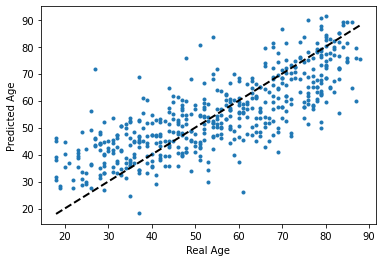

Regression Model : SVM
MAE: 8.78 
R2 Score: 0.62 


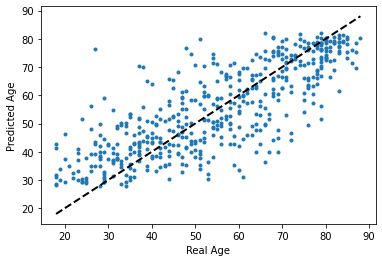

Regression Model : Regression Tree
MAE: 9.60 
R2 Score: 0.57 


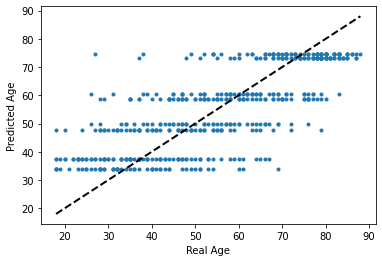

Regression Model : Random Forest
MAE: 9.68 
R2 Score: 0.56 


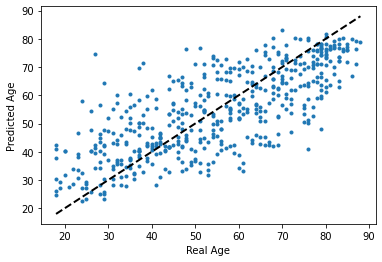

In [ ]:

# Print the mean and standard deviation of the scores
print('Regression Model : Linear')
print("MAE: %.2f " % lin_mae)
print("R2 Score: %.2f " % lin_r2)

fig, ax = plt.subplots()
ax.scatter(y, lin_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print('Regression Model : SVM')
print("MAE: %.2f " % svm_mae)
print("R2 Score: %.2f " % svm_r2)

fig, ax = plt.subplots()
ax.scatter(y, svm_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print('Regression Model : Regression Tree')
print("MAE: %.2f " % tree_mae)
print("R2 Score: %.2f " % tree_r2)

fig, ax = plt.subplots()
ax.scatter(y, tree_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print('Regression Model : Random Forest')
print("MAE: %.2f " % rf_mae)
print("R2 Score: %.2f " % rf_r2)

fig, ax = plt.subplots()
ax.scatter(y, rf_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()




### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-03-02 15:33:26--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-test-data.zip.7’

brainage-test-data. 100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-03-02 15:33:27 (231 MB/s) - ‘brainage-test-data.zip.7’ saved [1521/1521]

Archive:  brainage-test-data.zip
replace data/brain_age/meta/meta_data_regression_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


#### Run final testing

START TESTING...
+ TESTING 	Loss: 0.075865


Reference segmentation


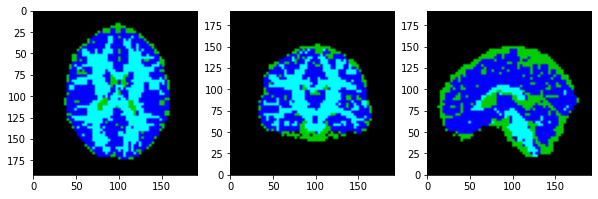

Predicted segmentation


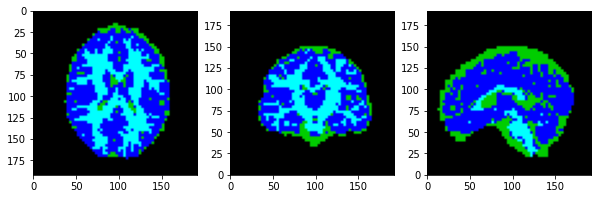

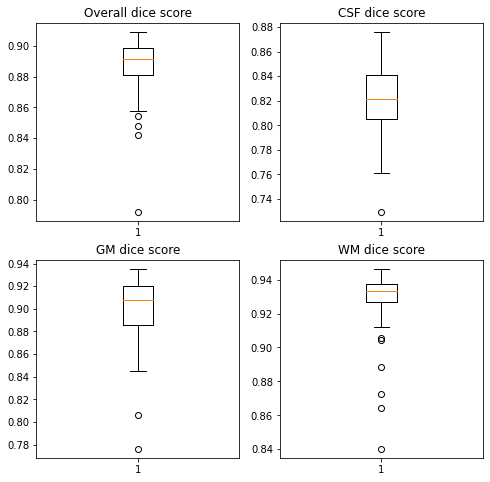

Calculating Features: 100%|██████████| 100/100 [00:00<00:00, 260.79it/s]


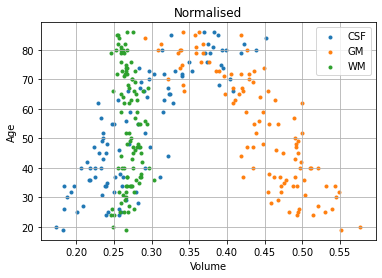

8.712122867729102   0.702146571468657
8.570512877856112   0.7032795543480681
9.805   0.4895211094389522


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:1044: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


8.257200000000001   0.7055823991237429
Regression Model : Linear
MAE: 8.71 
R2 Score: 0.70 


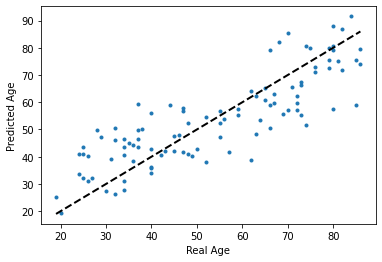

Regression Model : SVM
MAE: 8.57 
R2 Score: 0.70 


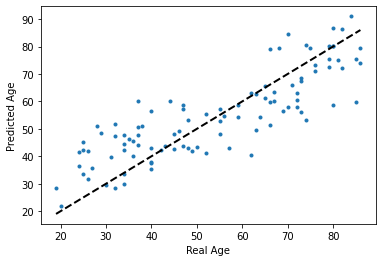

Regression Model : Regression Tree
MAE: 9.80 
R2 Score: 0.49 


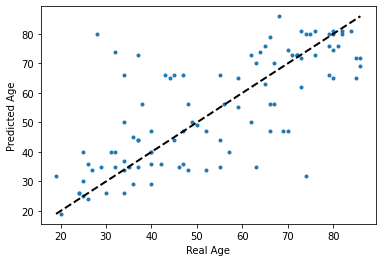

Regression Model : Random Forest
MAE: 8.26 
R2 Score: 0.71 


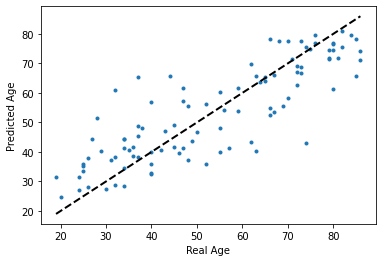

FINISHED TESTING


In [ ]:
########################################
# ADD YOUR CODE HERE
########################################

pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = SimpleUNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0

dice_scores = []
dice_scores_csf = []
dice_scores_gm = []
dice_scores_wm = []

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))


        # Calculate dice scores
        ref = sitk.GetImageFromArray(seg.cpu().squeeze().numpy().astype(np.uint8))
        ref.CopyInformation(sample['seg'])
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

        overlap_measures_filter.Execute(ref, prediction)
        dice_scores.append(overlap_measures_filter.GetDiceCoefficient())
        
        overlap_measures_filter.Execute((ref == 1), (prediction == 1))
        dice_scores_csf.append(overlap_measures_filter.GetDiceCoefficient())

        overlap_measures_filter.Execute((ref == 2), (prediction == 2))
        dice_scores_gm.append(overlap_measures_filter.GetDiceCoefficient())

        overlap_measures_filter.Execute((ref == 3), (prediction == 3))
        dice_scores_wm.append(overlap_measures_filter.GetDiceCoefficient())
        


        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

# Plot the dice scores indvidually 
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0,0].boxplot(dice_scores)
axs[0,0].set_title("Overall dice score")
axs[0,1].boxplot(dice_scores_csf)
axs[0,1].set_title("CSF dice score")
axs[1,0].boxplot(dice_scores_gm)
axs[1,0].set_title("GM dice score")
axs[1,1].boxplot(dice_scores_wm)
axs[1,1].set_title("WM dice score")
plt.show()


#A2

## CALCULATE RELATIVE TISSUE VOLUMES

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

vols_normalised = np.zeros((3,len(files_reg_seg_test)))

########################################
# ADD YOUR CODE HERE
########################################

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)

        segarray = sitk.GetArrayFromImage(seg)
         
        csf = np.sum(segarray == 1)
        gm = np.sum(segarray == 2)
        wm = np.sum(segarray == 3)

        total_brain_pixels = csf + gm + wm


        vols_normalised[0,idx] = csf/total_brain_pixels
        vols_normalised[1,idx] = gm/total_brain_pixels
        vols_normalised[2,idx] = wm/total_brain_pixels

plt.scatter(vols_normalised[0,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_test['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_test['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

X = vols_normalised.T
y = meta_data_reg_test['age'].values.reshape(-1,1)

#A3


########################################
# ADD YOUR CODE HERE
########################################

# Import required libraries
from sklearn import datasets, linear_model, svm, tree, preprocessing
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Load dataset (assuming 'X' and 'y' are already defined)

# Normalize the input features
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X)

# Define regression models
lin_regr = linear_model.LinearRegression()
svm_regr = svm.SVR()
tree_regr = tree.DecisionTreeRegressor()
nn_regr = MLPRegressor()
rf_regr = RandomForestRegressor(n_estimators=100)

# Define a range of hyperparameters to search over for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.1, 0.2, 0.5]
}

# Define a range of hyperparameters to search over for decision tree
tree_param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8]
}

# Define a range of hyperparameters to search over for neural network
nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'max_iter': [300, 500, 1000]
}


# Define a range of hyperparameters to search over for random forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'min_samples_split': [2, 4, 6, 8]
}


# Define a K-fold cross-validation object with 2 splits
kfold = KFold(n_splits=2, shuffle=True, random_state=1)

# Perform linear regression
lin_y_pred = cross_val_predict(lin_regr, X_norm, y, cv=kfold)
lin_mae = mean_absolute_error(y, lin_y_pred)
lin_r2 = r2_score(y, lin_y_pred)

print(lin_mae,' ',lin_r2)

# Perform support vector regression with grid search
svm_grid_search = GridSearchCV(svm_regr, svm_param_grid, cv=kfold, scoring='neg_mean_absolute_error')
svm_grid_search.fit(X_norm, y.ravel())
svm_y_pred = cross_val_predict(svm_grid_search.best_estimator_, X_norm, y.ravel(), cv=kfold)
svm_mae = mean_absolute_error(y, svm_y_pred)
svm_r2 = r2_score(y, svm_y_pred)

print(svm_mae,' ',svm_r2)

# Perform decision tree regression with grid search
tree_grid_search = GridSearchCV(tree_regr, tree_param_grid, cv=kfold, scoring='neg_mean_absolute_error')
tree_grid_search.fit(X_norm, y)
tree_y_pred = cross_val_predict(tree_grid_search.best_estimator_, X_norm, y, cv=kfold)
tree_mae = mean_absolute_error(y, tree_y_pred)
tree_r2 = r2_score(y, tree_y_pred)

print(tree_mae,' ',tree_r2)

#Perform random forest regression with grid search
#rf_grid_search = GridSearchCV(rf_regr, rf_param_grid, cv=kfold, scoring='neg_mean_absolute_error')
#rf_grid_search.fit(X_norm, y)
rf_y_pred = cross_val_predict(rf_regr, X, y, cv=kfold)
rf_mae = mean_absolute_error(y, rf_y_pred)
rf_r2 = r2_score(y, rf_y_pred)

print(rf_mae,' ',rf_r2)

print('Regression Model : Linear')
print("MAE: %.2f " % lin_mae)
print("R2 Score: %.2f " % lin_r2)

fig, ax = plt.subplots()
ax.scatter(y, lin_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print('Regression Model : SVM')
print("MAE: %.2f " % svm_mae)
print("R2 Score: %.2f " % svm_r2)

fig, ax = plt.subplots()
ax.scatter(y, svm_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print('Regression Model : Regression Tree')
print("MAE: %.2f " % tree_mae)
print("R2 Score: %.2f " % tree_r2)

fig, ax = plt.subplots()
ax.scatter(y, tree_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

print('Regression Model : Random Forest')
print("MAE: %.2f " % rf_mae)
print("R2 Score: %.2f " % rf_r2)

fig, ax = plt.subplots()
ax.scatter(y, rf_y_pred, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()



print('FINISHED TESTING')


## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

Import necessary modules and set relevant directories

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import SimpleITK as sitk

# data directory
data_dir = 'data/brain_age/'

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
! unzip brainage-data.zip
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-03-02 15:34:22--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip.8’

brainage-data.zip.8 100%[===================>] 446.94M  14.7MB/s    in 32s     

2023-03-02 15:34:56 (13.8 MB/s) - ‘brainage-data.zip.8’ saved [468654948/468654948]

Archive:  brainage-data.zip
replace data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.ni

Using the same image sampling as from part A where the images are normalized by subtracting the mean and dividing tby the standard deviation and then reshaped to 64x64x64

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)

class ImageDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)

            sample = {'img': img}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)

        return {'img': image}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

Helper functions to normalize and denormalize the age values (y) to between -1 and 1. The max and min ages 88 and 18 were foudn by finding the max and min ages in the metadata of all subjects.

In [ ]:
max_age = 88
min_age = 18

def normalize(arr, max_age, min_age, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max_age - min_age
    for i in arr:
        temp = (((i - min_age)*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return np.array(norm_arr)

def unnormalize(norm_arr, max_age, min_age, t_min, t_max):
    arr = []
    diff = t_max - t_min
    diff_arr = max_age - min_age
    for i in norm_arr:
        temp = (((i-t_min)*diff_arr)/diff)+min_age
        arr.append(temp)
    return np.array(arr)

In [ ]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev)))) 

Device: cuda:0
GPU: Tesla T4


In [ ]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 50
learning_rate = 0.001
batch_size = 2
val_interval = 5

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]

dataset_train = ImageDataset(files_reg_img_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False)

meta_data_reg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_reg_val = list(meta_data_reg_val['subject_id'])
files_reg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_val]

dataset_val = ImageDataset(files_reg_img_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]

dataset_test = ImageDataset(files_reg_img_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  6.08it/s]


Loading the data and labels into X and y arrays split for train, validation and test. The y values are also normalized and will be used for training the CNN.

In [ ]:
import os

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
X = np.zeros((0,1,64,64,64))

for batch_idx, batch_samples in enumerate(dataloader_train):
    
    img = batch_samples['img']
    # print(img.shape)
    # print(image_array.shape)
    X = np.append(X, img, axis=0)

In [ ]:
y = meta_data_reg_train['age'].values.reshape(-1,1)

y_normalized = normalize(y, max_age, min_age, -1, 1)

print(X.shape)
print(y_normalized.shape)

(500, 1, 64, 64, 64)
(500, 1)


In [ ]:
import os

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
X_val = np.zeros((0,1,64,64,64))

for batch_idx, batch_samples in enumerate(dataloader_val):
    
    img = batch_samples['img']
    # print(img.shape)
    # print(image_array.shape)
    X_val = np.append(X_val, img, axis=0)

In [ ]:
y_val = meta_data_reg_val['age'].values.reshape(-1,1)

y_val_normalized = normalize(y_val, max_age, min_age, -1, 1)

print(X_val.shape)
print(y_val_normalized.shape)

(47, 1, 64, 64, 64)
(47, 1)


In [ ]:
import os

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
X_test = np.zeros((0,1,64,64,64))

for batch_idx, batch_samples in enumerate(dataloader_test):
    
    img = batch_samples['img']
    # print(img.shape)
    # print(image_array.shape)
    X_test = np.append(X_test, img, axis=0)

In [ ]:
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

y_test_normalized = normalize(y_test, max_age, min_age, -1, 1)

print(X_test.shape)
print(y_test_normalized.shape)

(100, 1, 64, 64, 64)
(100, 1)


Defining the CNN.

In [ ]:
class Net(nn.Module):
    def __init__(self, output_dims = 1):
        super(Net, self).__init__()
        #### ADD YOUR CODE HERE ####
        self.feature_extractor = nn.Sequential (
        nn.Conv3d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.BatchNorm3d(6),
        nn.Tanh(),
        nn.MaxPool3d(kernel_size=2,stride=2), 
        nn.Dropout(0.2),
        nn.Conv3d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.BatchNorm3d(16),
        nn.Tanh(),
        nn.MaxPool3d(kernel_size=2,stride=2),
        nn.Dropout(0.2),
        nn.Conv3d(in_channels=16, out_channels=36, kernel_size=5, stride=1),
        nn.BatchNorm3d(36),
        nn.Tanh(),
        nn.MaxPool3d(kernel_size=2,stride=2),
        nn.Dropout(0.2),
        nn.Conv3d(in_channels=36, out_channels=output_dims, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm3d(output_dims),
        nn.Tanh(),
        nn.MaxPool3d(kernel_size=2,stride=2),
        nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential (
        nn.Linear(8,120),
        nn.Tanh(),
        nn.Linear(120,84),
        nn.Tanh(),
        nn.Linear(84,32),
        nn.Tanh(),
        nn.Linear(32, 10),
        nn.Tanh(),
        nn.Linear(10, output_dims)
        )




    def forward(self, x):
        x = x.reshape((x.size(0),1,64,64,64))
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Perform 2-fold cross-validation on the network.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

kf = KFold(n_splits=2, shuffle=True, random_state=rnd_seed)


mae_train_norm = 0
r2_train_norm = 0
mae_train_unnorm = 0
r2_train_unnorm = 0

torch.manual_seed(rnd_seed) #fix random seed

folds = 1
    
print('START TRAINING...')

for train,test in kf.split(X):
    print('Training over fold', folds, 'of 2')
    model = Net().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    for epoch in range(num_epochs):
        loss_curve = []
        loss_curve_val = []
        for idx, sample in enumerate(X[train]):
            img = torch.from_numpy(sample).to(device).float()
            y_hat = torch.from_numpy(y_normalized[train][idx]).to(device).float()
            optimizer.zero_grad()
            prd = model(img)
            loss = F.mse_loss(prd[0], y_hat)
            # print(prd[0],y_hat)
            # print(loss)
            loss_curve += [loss.item()]
            loss.backward()
            optimizer.step()


        print('\t+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, np.array(loss_curve).mean()))

        # Validation
        if epoch == 1 or epoch % val_interval == 0:
            loss_val = 0
            with torch.no_grad():
                for idx_val, sample_val in enumerate(X_val):
                    img_val = torch.from_numpy(sample_val).to(device).float()
                    y_hat_val = torch.from_numpy(y_val_normalized[idx_val]).to(device).float()
                    prd_val = model(img_val)
                    loss_val = F.mse_loss(prd_val[0], y_hat_val)
                    loss_curve_val += [loss_val.item()]

            print('--------------------------------------------------')
            print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, np.array(loss_curve_val).mean()))
            print('--------------------------------------------------')

    model.eval()
    predictions = []
    for idx_test, sample_test in enumerate(X[test]):
        img = torch.from_numpy(X[test][idx_test]).to(device).float()
        prediction = model(img).cpu().detach().numpy()
        predictions += [prediction.reshape((prediction.size))]
    
    mae_train_norm += mean_absolute_error(y_normalized[test], predictions)
    r2_train_norm += r2_score(y_normalized[test],predictions)
    
    predictions_unnormalized = unnormalize(predictions, max_age, min_age, -1, 1)

    mae_train_unnorm += mean_absolute_error(y[test],predictions_unnormalized)
    r2_train_unnorm += r2_score(y[test],predictions_unnormalized)

    folds += 1

print("\nAverage Training (normalized) MAE:", mae_train_norm/2, "\nAverage Training (normalized) R2:", r2_train_norm/2, "\n")
print("\nAverage Training (unnormalized) MAE:", mae_train_unnorm/2, "\nAverage Training (unnormalized) R2:", r2_train_unnorm/2, "\n")

START TRAINING...
Training over fold 1 of 2
	+ TRAINING 	Epoch: 0 	Loss: 0.312617
--------------------------------------------------
+ VALIDATE 	Epoch: 0 	Loss: 0.277672
--------------------------------------------------
	+ TRAINING 	Epoch: 1 	Loss: 0.271238
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.185065
--------------------------------------------------
	+ TRAINING 	Epoch: 2 	Loss: 0.198565
	+ TRAINING 	Epoch: 3 	Loss: 0.190895
	+ TRAINING 	Epoch: 4 	Loss: 0.155556
	+ TRAINING 	Epoch: 5 	Loss: 0.150296
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.098054
--------------------------------------------------
	+ TRAINING 	Epoch: 6 	Loss: 0.129230
	+ TRAINING 	Epoch: 7 	Loss: 0.124258
	+ TRAINING 	Epoch: 8 	Loss: 0.110768
	+ TRAINING 	Epoch: 9 	Loss: 0.109182
	+ TRAINING 	Epoch: 10 	Loss: 0.113368
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.102182
-------------------------------

Train the network on all the training data using the validation set for validation.

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score


torch.manual_seed(rnd_seed) #fix random seed
    
print('START TRAINING...')

final_model = Net().to(device)
final_model.train()
optimizer = torch.optim.Adam(final_model.parameters(),lr=learning_rate)

X_train, y_train = X, y_normalized

for epoch in range(num_epochs):
    loss_curve = []
    loss_curve_val = []
    for idx, sample in enumerate(X_train):
        img = torch.from_numpy(sample).to(device).float()
        y_hat = torch.from_numpy(y_train[idx]).to(device).float()
        optimizer.zero_grad()
        prd = final_model(img)
        loss = F.mse_loss(prd[0], y_hat)
        # print(prd[0],y_hat)
        # print(loss)
        loss_curve += [loss.item()]
        loss.backward()
        optimizer.step()


    print('\t+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, np.array(loss_curve).mean()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        with torch.no_grad():
            for idx_val, sample_val in enumerate(X_val):
                img_val = torch.from_numpy(sample_val).to(device).float()
                y_hat_val = torch.from_numpy(y_val_normalized[idx_val]).to(device).float()
                prd_val = final_model(img_val)
                loss_val = F.mse_loss(prd_val[0], y_hat_val)
                loss_curve_val += [loss_val.item()]

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, np.array(loss_curve_val).mean()))
        print('--------------------------------------------------')


START TRAINING...
	+ TRAINING 	Epoch: 0 	Loss: 0.265201
--------------------------------------------------
+ VALIDATE 	Epoch: 0 	Loss: 0.166570
--------------------------------------------------
	+ TRAINING 	Epoch: 1 	Loss: 0.191045
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.131708
--------------------------------------------------
	+ TRAINING 	Epoch: 2 	Loss: 0.172273
	+ TRAINING 	Epoch: 3 	Loss: 0.139434
	+ TRAINING 	Epoch: 4 	Loss: 0.132606
	+ TRAINING 	Epoch: 5 	Loss: 0.120336
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.120860
--------------------------------------------------
	+ TRAINING 	Epoch: 6 	Loss: 0.116527
	+ TRAINING 	Epoch: 7 	Loss: 0.109583
	+ TRAINING 	Epoch: 8 	Loss: 0.098466
	+ TRAINING 	Epoch: 9 	Loss: 0.091421
	+ TRAINING 	Epoch: 10 	Loss: 0.084942
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.113423
--------------------------------------------------
	+ TRA

In [ ]:
torch.save(final_model.state_dict(), os.path.join(model_dir, 'cnn_model.pt'))

Testing the final model on the 100 held out test subjects and calculating the MAE and R2 values on the normalized data

In [ ]:
final_model = Net().to(device)
final_model.load_state_dict(torch.load(os.path.join(model_dir, 'cnn_model.pt')))

final_model.eval()
predictions_test = []
for idx_test, sample_test in enumerate(X_test):
    img = torch.from_numpy(X_test[idx_test]).to(device).float()
    prediction_test = final_model(img).cpu().detach().numpy()
    predictions_test += [prediction_test.reshape((prediction_test.size))]

mae_test = mean_absolute_error(y_test_normalized, predictions_test)
r2_test = r2_score(y_test_normalized, predictions_test)

print("\nTest (normalized) MAE:", mae_test, "\nTest (normalized) R2:", r2_test, "\n")


Test (normalized) MAE: 0.214046172901988 
Test (normalized) R2: 0.7752009762289742 



Unnormalizing the calculated ages so it can be compared to the true y labels

In [ ]:
predictions_unnormalized = unnormalize(predictions_test, max_age, min_age, -1, 1)
print(predictions_unnormalized.shape)

(100, 1)


Scatter plot of predicted ages vs true ages

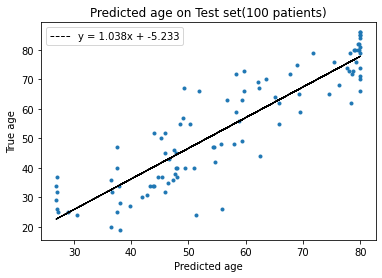

In [ ]:
plt.figure()
plt.scatter(predictions_unnormalized.flatten(),y_test.flatten(),marker = '.')

m, b = np.polyfit(predictions_unnormalized.flatten(), y_test.flatten(), 1)
plt.plot(predictions_unnormalized.flatten(), m*np.array(predictions_unnormalized.flatten()) + b, 'k--', label = 'y = '+str(round(m,3)) + 'x + ' + str(round(b,3)), lw=1)
plt.title('Predicted age on Test set(100 patients)')
plt.xlabel('Predicted age')
plt.ylabel('True age')
plt.legend()

Finding the MAE and R2 of the unnormalized predicted and true ages.

In [ ]:
mae_unnorm = mean_absolute_error(y_test, predictions_unnormalized)
r2_unnorm = r2_score(y_test,predictions_unnormalized)

print("\nTest (unnormalized) MAE:", mae_unnorm, "\nTest (unnormalized) R2:", r2_unnorm, "\n")


Test (unnormalized) MAE: 7.491615810394287 
Test (unnormalized) R2: 0.7752009762470624 

